In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import warnings

plt.style.use('ggplot')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
print(df.columns)
print(df.shape)

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')
(1319, 12)


In [4]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [5]:
df.card = (df.card == 'yes').astype(int)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [7]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1,1,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
2,1,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13
3,0,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0
4,1,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19


In [8]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [9]:
categorical = ['owner', 'selfemp']
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

In [10]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f'column: {c}, auc: {round(auc,3)}')

column: reports, auc: 0.717
column: age, auc: 0.524
column: income, auc: 0.591
column: share, auc: 0.989
column: expenditure, auc: 0.991
column: dependents, auc: 0.533
column: months, auc: 0.529
column: majorcards, auc: 0.534
column: active, auc: 0.604


Question 1 - Reports

In [11]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [12]:
train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [13]:
auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))

0.995


Question 2 - 0.995

In [14]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp' ,'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [15]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [16]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [17]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000
2,0.02,211,31,0,22,1.000000,0.584906,0.871901,1.000000
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000
...,...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,0.966825,0.000000,1.000000,0.966825
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346


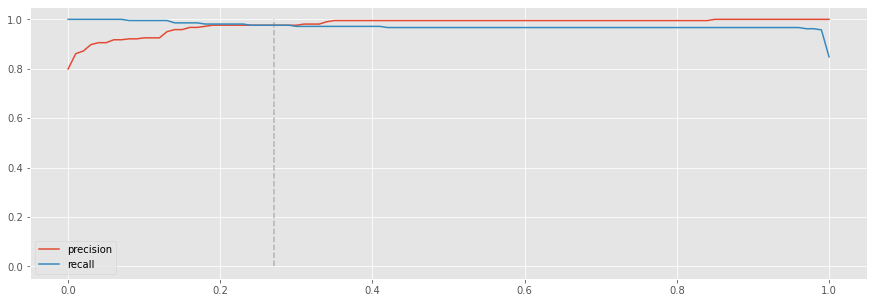

In [18]:
plt.figure(figsize=(15, 5))

plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.vlines(0.27, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

Question 3 - Approximately 0.3

In [19]:
df_scores['f1'] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

In [20]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,1.000000,0.584906,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,0.966825,0.000000,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346,0.978208


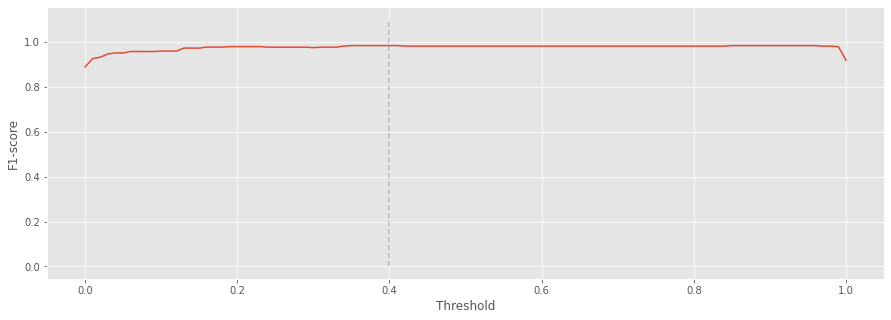

In [21]:
plt.figure(figsize=(15, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.4, 0, 1.1, color='grey', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

Question 4 - Approximately 0.4

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


Question 5 - STD is 0.003

In [24]:
%%capture
!pip install tqdm

In [25]:
from tqdm.auto import  tqdm

In [26]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10], total=n_splits):
    scores = []

    kFold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kFold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001 0.989 +- 0.007
C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=0.5 0.996 +- 0.003
C=1 0.996 +- 0.003
C=5 0.996 +- 0.003
C=10 0.996 +- 0.003


Question 6 - Best C is 1